<a href="https://colab.research.google.com/github/danielmlow/tutorials/blob/main/speech_shaped_noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speech-shaped noise

Noise shaped with speech's amplitude. Impose intensity contour (influenced by syllable rate, phonetic structure). 

Not recommended to do with single word, because the strongest segment might be the vowel. So the noise will sound like the vowel and its spectrum will look like the vowel's spectrum.

Steps:
1. Create noise by adding speech segments together
2. Load target audio
2. Apply Hilbert transform to extract envelope.
3. Multiply envelope x noise to obtain 

In [9]:
import os 
import pandas as pd
import numpy as np
import random
import datetime
from scipy.io import wavfile
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import display, Audio
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy import signal
from sklearn.preprocessing import MinMaxScaler


In [2]:
from google.colab import drive
# Get access to Google Drive and attach it to the colab for data I/O. Follow instructions:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# figure config
plt.rcParams['figure.figsize'] = [12, 2]
plt.rcParams['figure.dpi'] = 120

In [4]:
#@title

# Load audio files from huggingface datasets
# !pip install datasets
# from datasets import load_dataset, load_from_disk
# # dataset = load_dataset('ami', 'headset-single', split='test') 

# load_from_disk("path/to/dataset")
# dataset = load_dataset('ami-wav2vec2/ami_single_headset_segmented_and_chunked')
# # dataset = load_dataset("ami-wav2vec2/ami_single_headset_segmented_and_chunked")


# # https://huggingface.co/datasets/ami
# #other: https://huggingface.co/datasets/timit_asr

# https://huggingface.co/docs/datasets/audio_process.html

# concat many 2 sec speech signals
# speech_samples = []
# for i in list(range(0,dataset.shape[0],5)):
#   data = dataset[i]["audio"]['array']
#   speech_samples.append(data)

# print(np.array(speech_samples).shape, 'audio signal vectors')
# speech_samples = np.concatenate(speech_samples)
# print(speech_samples.shape, 'a single vector concatenated')


# # take random n seconds from concatenated and sum 
# n_seconds = 30
# repeat = 50
# # obtain 1 segment to build the array
# random_start =random.randint(0,len(speech_samples)-(n_seconds*sr))
# speech_noise = speech_samples[random_start:random_start+n_seconds*sr]

# # take 50 more and sum them to that array
# for i in range(repeat):
#   random_start = random.randint(0,len(speech_samples)-(n_seconds*sr))
#   random_n_seconds = speech_samples[random_start:random_start+n_seconds*sr]
#   speech_noise+=random_n_seconds

# # speech_noise = speech_noise/repeat #average



44100


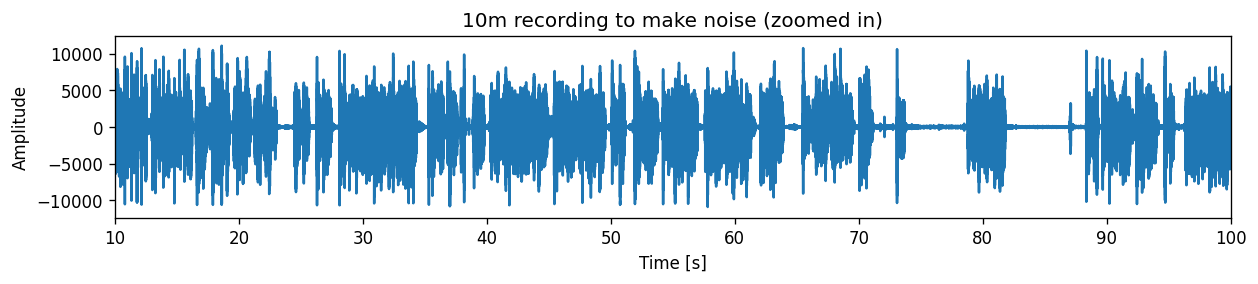

different segment:


In [74]:
# plot speech signal used to make noise
input_dir='/content/drive/My Drive/datum/umass/audio_samples/' #CHANGE TO YOUR PATH
sr, data = wavfile.read(input_dir+'oprah_megan.wav')
print(sr)
data = data[:,0]
data = data[100000:]
duration = len(data)/sr
time = np.arange(0,duration,1/sr) #time vector
plt.plot(time,data)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('10m recording to make noise (zoomed in)')
plt.xlim((10,100))
plt.show()
print('different segment:')
display(Audio(data=data.T[1000000:1500000], rate=sr, autoplay=False))

In [77]:
# sum N M-second segements from recording to create noise. 

load_noise = True # if already created, to save time

if load_noise:
  speech_noise = np.load(input_dir+'../speech_noise_oprah_megan_10000_30.npy')
else:
  repeat = 10000 # N
  n_seconds = 30 # M 
  random_start = random.randint(0,len(data)-(n_seconds*sr))
  speech_noise = data[random_start:random_start+n_seconds*sr] #get random 30 seconds
  speech_noise = np.divide(speech_noise, max(abs(speech_noise))) #normalize
  for i in range(repeat):
    random_start = random.randint(0,len(data)-(n_seconds*sr))
    random_n_seconds = data[random_start:random_start+n_seconds*sr] #get random 30 seconds
    random_n_seconds = np.divide(random_n_seconds, max(abs(random_n_seconds))) #normalize
    speech_noise= np.add(speech_noise,random_n_seconds) #add to other segement
    speech_noise = np.divide(speech_noise, max(abs(speech_noise))) #normalize
  
  np.save(input_dir+f'../speech_noise_oprah_megan_{repeat}_{n_seconds}.npy', speech_noise)

speech_noise.shape

(1323000,)

In [98]:
def speech_shaped_noise(path_to_wav,noise=None,scale_envelope = True, filter_envelope=True, gen_figures=True, play_audio=True,save_audio=False, output_path = None):
  # signal
  print('\n\n====='+path_to_wav)
  sr, data = wavfile.read(path_to_wav)
  print('samplig rate: ',sr)
  data = data [:,0] #extract single channel
  duration = len(data)/sr
  time = np.arange(0,duration,1/sr) #time vector
  scaler = MinMaxScaler()
  if gen_figures:
    plt.plot(time,data)
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.title(path_to_wav)
    plt.show()
  if play_audio:
    display(Audio(data=data.T, rate=sr, autoplay=False))
  
  # Envelope: extract amplitude envelope through Hilbert transform https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.hilbert.html
  analytic_signal = hilbert(data)
  amplitude_envelope = np.abs(analytic_signal)
  if scale_envelope:
    amplitude_envelope_before_scaling = amplitude_envelope.copy()
    amplitude_envelope = scaler.fit_transform(amplitude_envelope.reshape(-1, 1)).flatten()
  if filter_envelope: # to capture slower speech rate frequencies instead of pitch period
    b, a = signal.butter(8, 50 / (sr / 2) )
    filt_env = signal.filtfilt(b, a, amplitude_envelope, method="gust")
  if gen_figures:
    t = np.arange(len(data)) / sr
    plt.plot(t, data, label='signal')
    plt.plot(t, amplitude_envelope_before_scaling, label='envelope before scaling', c='orange',linestyle='dashed', alpha=0.5)
    plt.xlabel("time in seconds")
    plt.legend()
    plt.xlim((0.3,0.35))
    plt.title('Signal and amplitude envelope through Hilbert transform\nNote: envelope is later scaled to (0,1)')
    plt.show()
  
  # Noise: generate if noise == None, else load noise from argument
  if np.sum(noise == None): 
    print('generating noise...')
    num_samples = len(data)
    noise = np.random.uniform(num_samples)*2-1
  if gen_figures:
    plt.plot(noise)
    plt.title('Speech noise: noise made from adding 30-sec random clips from 10m interview recording (zoomed in, 30 sec total)')
    plt.show()

  noise_matched_length = noise[:data.shape[0]] # Take a segment of noise of similar length as audio
  display(Audio(data=noise_matched_length.T, rate=sr, autoplay=False))
  
  # Speech shaped noise
  speech_shaped_noise = noise_matched_length*amplitude_envelope
  if gen_figures:
    plt.plot(speech_shaped_noise)
    plt.title('Speech-shaped noise')
    plt.show()
  if play_audio:
    display(Audio(data=speech_shaped_noise.T, rate=sr, autoplay=False))
  if save_audio:
    wavfile.write(output_path+".wav",sr, speech_shaped_noise.astype(np.int16))
  
  # Plot Speech spectrum
  start =-100
  end=100
  plt.magnitude_spectrum(data, Fs=sr, scale='dB', color='C1')
  plt.title("Log. Magnitude Spectrum - Speech")
  # plt.ylim(start,end) 
  plt.xlim(0,6000) 
  plt.show()

  # Plot Speech spectrum
  plt.magnitude_spectrum(noise_matched_length, Fs=sr, scale='dB', color='C1')
  plt.title("Log. Magnitude Spectrum - Noise")
  # plt.ylim(start,end) 
  plt.xlim(0,6000) 
  plt.show()
  
  # Plot Speech-shaped noise spectrum
  plt.magnitude_spectrum(speech_shaped_noise, Fs=sr, scale='dB', color='C1')
  plt.title("Log. Magnitude Spectrum - Speech-shaped noise")
  # plt.ylim(start,end) 
  plt.xlim(0,6000)
  plt.show()
  



In [101]:
# Debug filter, then set to True when running the function
# Load data
sr, data = wavfile.read('/content/drive/My Drive/datum/umass/stimuli/TR_04_OwlBabies Clip.wav')
data = data [:,0] #extract single channel
duration = len(data)/sr
time = np.arange(0,duration,1/sr) #time vector
scaler = MinMaxScaler()  
print(np.isfinite(data).any()) #check for inf and nans
data = np.ma.masked_array(data, ~np.isfinite(data)).filled(0) #replace inf and nans
print(np.isfinite(data).any()) #check for inf and nans
# extract envelope
analytic_signal = hilbert(data)
amplitude_envelope = np.abs(analytic_signal)
amplitude_envelope = scaler.fit_transform(amplitude_envelope.reshape(-1, 1)).flatten()
print(np.isfinite(amplitude_envelope).any()) #check for inf and nans
amplitude_envelope = np.ma.masked_array(amplitude_envelope, ~np.isfinite(amplitude_envelope)).filled(0)#replace inf and nans
print(np.isfinite(amplitude_envelope).any()) #check for inf and nans
b, a = signal.butter(8, 50 / (sr / 2) )
signal.filtfilt(b, a, amplitude_envelope, method="gust")

True
True
True
True


ValueError: ignored

['TR_04_OwlBabies Clip.wav']


=====/content/drive/My Drive/datum/umass/stimuli/TR_04_OwlBabies Clip.wav
samplig rate:  44100


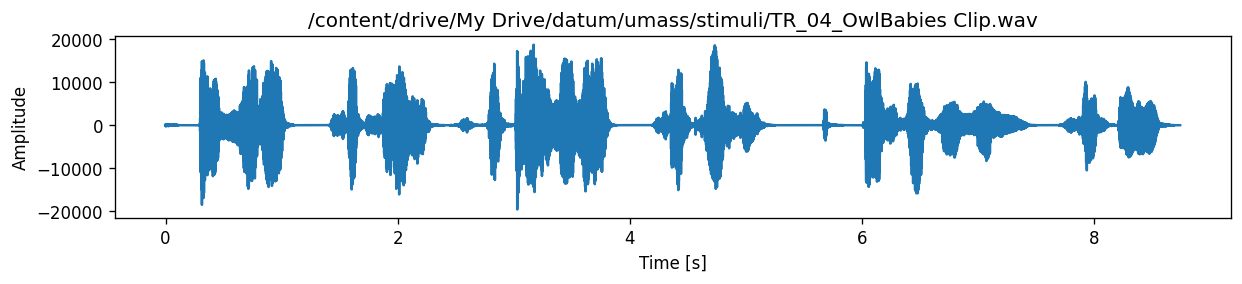

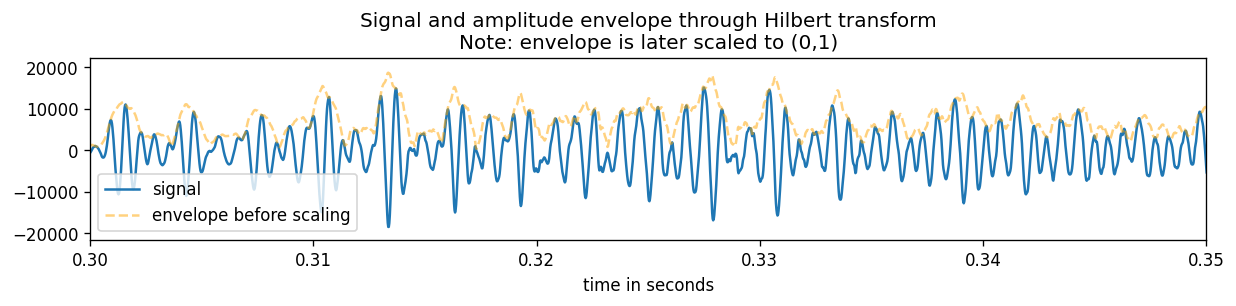

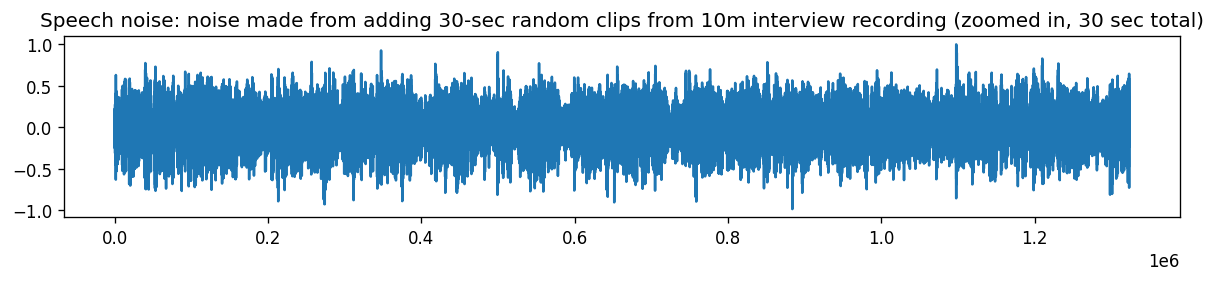

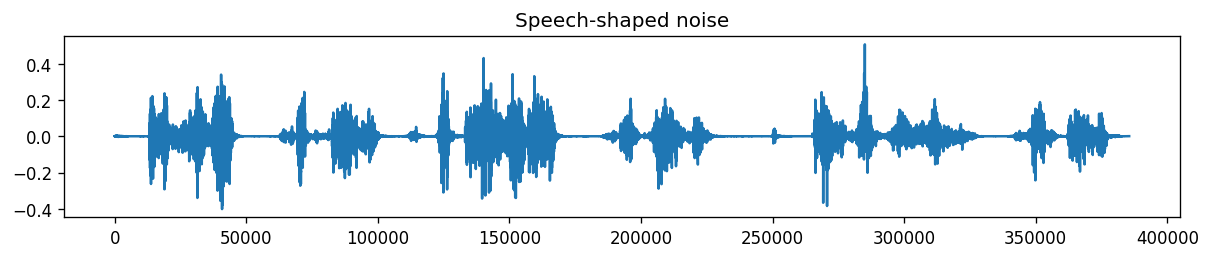

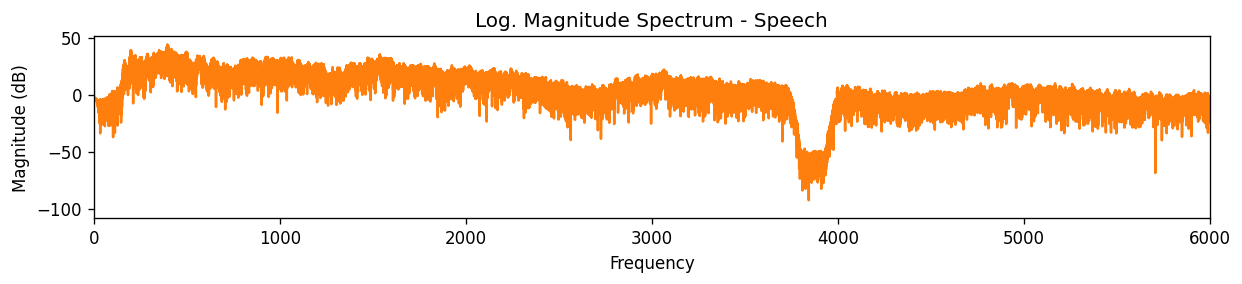

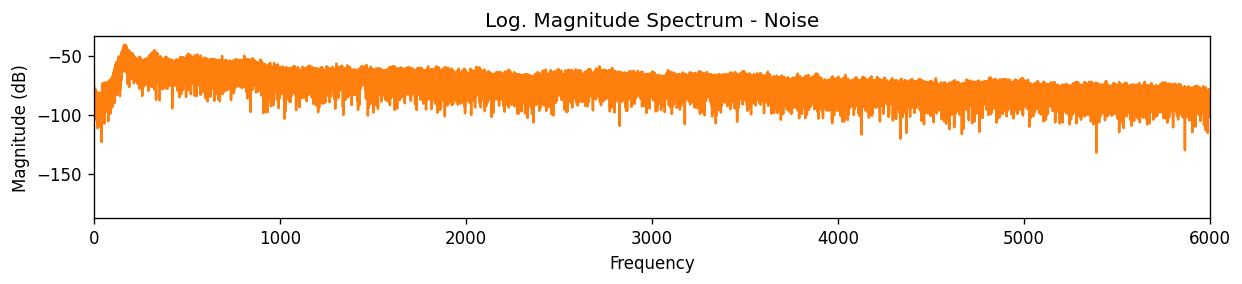

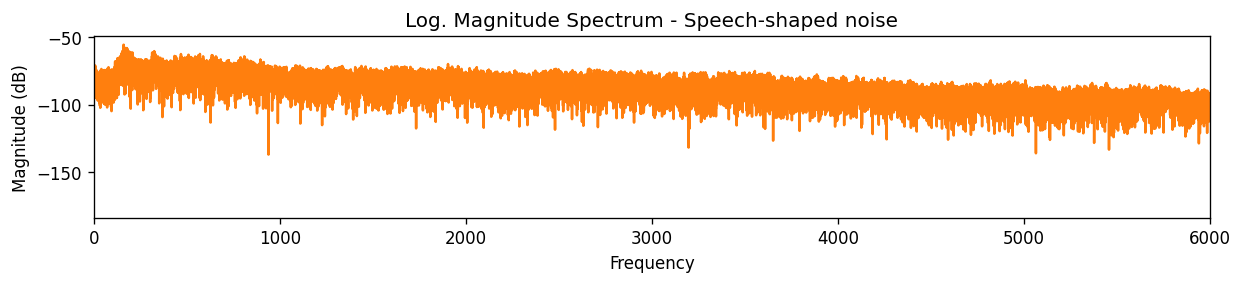

In [100]:
# Make speech-shaped noise from target audio recording
input_dir='/content/drive/My Drive/datum/umass/stimuli/' #CHANGE TO YOUR PATH
output_dir='/content/drive/My Drive/datum/umass/speech_shaped_noise/' #CHANGE TO YOUR PATH

try: os.mkdir(output_dir)
except: pass

wav_files = os.listdir(input_dir) #for now: ['TR_04_OwlBabies Clip.wav']
print(wav_files)

for wav_file in wav_files:
  speech_shaped_noise(input_dir+wav_file, 
                      noise=speech_noise, 
                      scale_envelope = True, 
                      filter_envelope = False, #set to True once you debug
                      gen_figures=True, 
                      play_audio=True, 
                      save_audio=True, 
                      output_path = output_dir+wav_file[:-4]
                      )